In [18]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import csv
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as util
import os

# Data Preprocessing

In [7]:
data_labels, lexical_data, acoustic_data, visual_data = [], [], [], []
reader = csv.reader(open("dataset.csv"), delimiter=',')
next(reader)

for row in reader:
    visual_data.append(np.load(row[2][1:]))
    acoustic_data.append(np.load(row[3][1:]))
    lexical_data.append(np.load(row[4][1:]))
    data_labels.append(int(row[5]))

# Labels
data_labels = torch.from_numpy(np.asarray(data_labels))

 
# Lexical Data
lexical_data = torch.from_numpy(np.asarray(lexical_data))
lexical_dataset = util.data.TensorDataset(lexical_data, data_labels)

# Acoustic Data - first pad, then convert into tensor
acoustic_max = max([len(tens) for tens in acoustic_data])
for i, tens in enumerate(acoustic_data):
    dist = acoustic_max - len(tens)
    tens = np.pad(tens, pad_width=[(0,dist), (0,0)], mode='constant')
    acoustic_data[i] = tens
    
acoustic_data = torch.from_numpy(np.asarray(acoustic_data))
acoustic_dataset = util.data.TensorDataset(acoustic_data, data_labels)


# Visual Data - first pad, then convert into tensor
visual_max = max([len(tens) for tens in visual_data])
for i, tens in enumerate(visual_data):
    dist = visual_max - len(tens)
    tens = np.pad(tens, pad_width=[(0,dist), (0,0)], mode='constant')
    visual_data[i] = tens
    
visual_data = torch.from_numpy(np.asarray(visual_data)).type('torch.DoubleTensor') # need to explicitly cast as double
visual_dataset = util.data.TensorDataset(visual_data, data_labels)



In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
print('Visual Data Shape: ' + str(visual_data.shape))
print('Acoustic Data Shape: ' +  str(acoustic_data.shape))
print('Lexical Data Shape: ' +  str(lexical_data.shape))
print('Labels Shape: ' +  str(data_labels.shape))

Visual Data Shape: torch.Size([1336, 716, 2048])
Acoustic Data Shape: torch.Size([1336, 24, 128])
Lexical Data Shape: torch.Size([1336, 768])
Labels Shape: torch.Size([1336])


# Lexical Model

## Model Definition

In [12]:
class LexicalModel(nn.Module):
    def __init__(self):
        super(LexicalModel, self).__init__()
        self.fc1 = nn.Linear(768, 230)
        self.batch1 = nn.BatchNorm1d(230)
        self.fc2 = nn.Linear(230, 50)
        self.batch2 = nn.BatchNorm1d(50)
        self.fc3 = nn.Linear(50, 4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
      
    # batchnorm wrecks this for some reason
    def forward(self, x):
        x = self.fc1(x)
#         x = self.batch1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
#         x = self.batch2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

## Training and Testing Lexical Model

In [13]:
lex = LexicalModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lex.parameters(), lr=1e-4)

k_folds = 10
num_epochs = 20

k_fold_results = {}

total_lexical_predicted, total_lexical_targets = [], []

kfold = KFold(n_splits=k_folds, shuffle=True)


for fold, (train_ids, test_ids) in enumerate(kfold.split(lexical_dataset)):
    print(f"Fold {fold}")
    print('----------------------------')
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    lexical_trainloader = torch.utils.data.DataLoader(lexical_dataset, batch_size=10,
                                          sampler=train_subsampler)
    lexical_testloader = torch.utils.data.DataLoader(lexical_dataset, batch_size=10,
                                          sampler=test_subsampler)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times


        running_loss = 0.0
        for i, data in enumerate(lexical_trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = lex(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
#             if i % 100 == 99:    # print every 200 mini-batches
#                 print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss / 100))
#                 running_loss = 0.0

    print('Finished Training - Testing Begins')
    
    correct, total = 0,0
    
    with torch.no_grad():
        # Iterate over the test data and generate predictions
        for i, data in enumerate(lexical_testloader, 0):

            # Get inputs
            inputs, targets = data

            # Generate outputs
            outputs = lex(inputs)

            # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            
            total_lexical_predicted += predicted
            total_lexical_targets += targets
            correct += (predicted == targets).sum().item()
        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')
        k_fold_results[fold] = 100.0 * (correct / total)
    
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in k_fold_results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(k_fold_results.items())} %')

Fold 0
----------------------------
Finished Training - Testing Begins
Accuracy for fold 0: 63 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 63.43283582089553 %
Average: 63.43283582089553 %
Fold 1
----------------------------
Finished Training - Testing Begins
Accuracy for fold 1: 78 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 63.43283582089553 %
Fold 1: 78.35820895522389 %
Average: 70.8955223880597 %
Fold 2
----------------------------
Finished Training - Testing Begins
Accuracy for fold 2: 90 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 63.43283582089553 %
Fold 1: 78.35820895522389 %
Fold 2: 90.29850746268657 %
Average: 77.363184079602 %
Fold 3
----------------------------
Finished Training - Testing Begins
Accuracy for fold 3: 96 %
---------------------------

## Lexical Results with Confusion Matrix

Lexical Confusion Matrix with F1 Score: 0.8997005988023952
--------------------------------
Confusion matrix, without normalization
[[303   2   3  20]
 [  5 266  10  27]
 [  1   7 150  22]
 [ 15  14   8 483]]


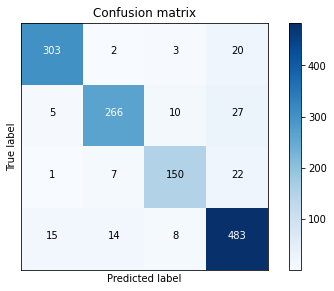

In [20]:
lexical_f1 = f1_score(total_lexical_targets, total_lexical_predicted, average='micro')
lexical_cm = confusion_matrix(total_lexical_targets, total_lexical_predicted)

# probably a better way to do this
classes = np.ndarray([0,1,2,3])

print(f'Lexical Confusion Matrix with F1 Score: {lexical_f1}')
print('--------------------------------')
plot_confusion_matrix(lexical_cm, classes)

# Acoustic Model

In [23]:
class AcousticModel(nn.Module):
    def __init__(self, pool_size):
        super(AcousticModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=24, kernel_size=1, out_channels=16)
        self.conv2 = nn.Conv1d(in_channels=16, kernel_size=1, out_channels=8)
        self.pool1 = nn.MaxPool1d(pool_size, stride=pool_size)
#         self.pool1 = nn.AvgPool1d(pool_size, stride=pool_size)
    

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(256, 64)
        self.batch1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(64, 16)
        self.batch2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(16, 4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
      
    # batchnorm wrecks this for some reason
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu(x)
        x = self.pool1(x)
        
#         print(x.shape)
        
        x = self.flatten(x)
        x = self.fc1(x)
#         x = self.batch1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
#         x = self.batch2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

## Training And Testing Acoustic Model

In [24]:
acoust = AcousticModel(pool_size=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(acoust.parameters(), lr=1e-4)

k_folds = 10
num_epochs = 20

total_acoustic_predicted, total_acoustic_targets = [], []

k_fold_results = {}

kfold = KFold(n_splits=k_folds, shuffle=True)


for fold, (train_ids, test_ids) in enumerate(kfold.split(acoustic_dataset)):
    print(f"Fold {fold}")
    print('----------------------------')
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    acoustic_trainloader = torch.utils.data.DataLoader(acoustic_dataset, batch_size=10,
                                          sampler=train_subsampler)
    acoustic_testloader = torch.utils.data.DataLoader(acoustic_dataset, batch_size=10,
                                          sampler=test_subsampler)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times


        running_loss = 0.0
        for i, data in enumerate(acoustic_trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = acoust(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
#             if i % 100 == 99:    # print every 200 mini-batches
#                 print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss / 100))
#                 running_loss = 0.0

    print('Finished Training - Testing Begins')
    
    correct, total = 0,0
    
    with torch.no_grad():
        # Iterate over the test data and generate predictions
        for i, data in enumerate(acoustic_testloader, 0):

            # Get inputs
            inputs, targets = data

            # Generate outputs
            outputs = acoust(inputs)

            # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            
            total_acoustic_predicted += predicted
            total_acoustic_targets += targets
            
            
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')
        k_fold_results[fold] = 100.0 * (correct / total)
    
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in k_fold_results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(k_fold_results.items())} %')

Fold 0
----------------------------
Finished Training - Testing Begins
Accuracy for fold 0: 46 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 46.26865671641791 %
Average: 46.26865671641791 %
Fold 1
----------------------------
Finished Training - Testing Begins
Accuracy for fold 1: 54 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 46.26865671641791 %
Fold 1: 54.47761194029851 %
Average: 50.373134328358205 %
Fold 2
----------------------------
Finished Training - Testing Begins
Accuracy for fold 2: 58 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 46.26865671641791 %
Fold 1: 54.47761194029851 %
Fold 2: 58.2089552238806 %
Average: 52.98507462686567 %
Fold 3
----------------------------
Finished Training - Testing Begins
Accuracy for fold 3: 51 %
------------------------

## Acoustic Results with Confusion Matrix

Acoustic Confusion Matrix with F1 Score: 0.563622754491018
--------------------------------
Confusion matrix, without normalization
[[207  11   2 108]
 [ 19 176   2 111]
 [ 40  34   2 104]
 [ 70  80   2 368]]


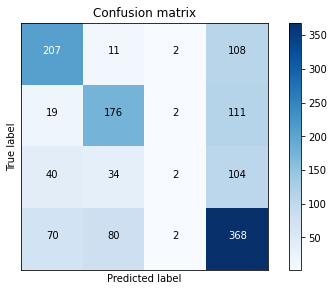

In [25]:
acoustic_f1 = f1_score(total_acoustic_targets, total_acoustic_predicted, average='micro')
acoustic_cm = confusion_matrix(total_acoustic_targets, total_acoustic_predicted)

# probably a better way to do this
classes = np.ndarray([0,1,2,3])

print(f'Acoustic Confusion Matrix with F1 Score: {acoustic_f1}')
print('--------------------------------')
plot_confusion_matrix(acoustic_cm, classes)

# Visual Model

In [43]:
class VisualModel(nn.Module):
    def __init__(self, pool_1_size, pool_2_size):
        super(VisualModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=716, kernel_size=1, out_channels=8).double()
        self.batch1 = nn.BatchNorm1d(8)
        self.pool1 = nn.MaxPool1d(pool_1_size, stride=pool_1_size)
        self.pool2 = nn.MaxPool1d(pool_2_size, stride=pool_2_size)
        self.conv2 = nn.Conv1d(in_channels=8, kernel_size=1, out_channels=1).double()
        self.batch2 = nn.BatchNorm1d(1)

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(64, 32)

        self.fc2 = nn.Linear(32, 16)
        
        self.fc3 = nn.Linear(16, 4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
      
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.dropout(x)
        
#         print(x.shape)
        
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
#         print(x.shape)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        return x

## Training and Testing Visual Model

In [44]:
visual = VisualModel(pool_1_size=8, pool_2_size=4).double()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(visual.parameters(), lr=1e-4)

k_folds = 10
num_epochs = 10

total_visual_predicted, total_visual_targets = [], []

k_fold_results = {}

kfold = KFold(n_splits=k_folds, shuffle=True)


for fold, (train_ids, test_ids) in enumerate(kfold.split(visual_dataset)):
    print(f"Fold {fold}")
    print('----------------------------')
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    visual_trainloader = torch.utils.data.DataLoader(visual_dataset, batch_size=10,
                                          sampler=train_subsampler)
    visual_testloader = torch.utils.data.DataLoader(visual_dataset, batch_size=10,
                                          sampler=test_subsampler)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times


        running_loss = 0.0
        for i, data in enumerate(visual_trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = visual(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
#             print(i)
            
#             if i % 100 == 99:    # print every 200 mini-batches
#                 print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss / 100))
#                 running_loss = 0.0

    print('Finished Training - Testing Begins')
    
    correct, total = 0,0
    
    with torch.no_grad():
        # Iterate over the test data and generate predictions
        for i, data in enumerate(visual_testloader, 0):

            # Get inputs
            inputs, targets = data

            # Generate outputs
            outputs = visual(inputs)

            # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            
            total_visual_predicted += predicted
            total_visual_targets += targets
            
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')
        k_fold_results[fold] = 100.0 * (correct / total)
    
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in k_fold_results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(k_fold_results.items())} %')

Fold 0
----------------------------
Finished Training - Testing Begins
Accuracy for fold 0: 29 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 29.1044776119403 %
Average: 29.1044776119403 %
Fold 1
----------------------------
Finished Training - Testing Begins
Accuracy for fold 1: 39 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 29.1044776119403 %
Fold 1: 39.55223880597015 %
Average: 34.32835820895522 %
Fold 2
----------------------------
Finished Training - Testing Begins
Accuracy for fold 2: 44 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 29.1044776119403 %
Fold 1: 39.55223880597015 %
Fold 2: 44.776119402985074 %
Average: 37.81094527363184 %
Fold 3
----------------------------
Finished Training - Testing Begins
Accuracy for fold 3: 44 %
---------------------------

## Visual Results and Confusion Matrix

Lexical Confusion Matrix with F1 Score: 0.8787425149700597
--------------------------------
Confusion matrix, without normalization
[[298   6   2  22]
 [  6 271   4  27]
 [  3   8 140  29]
 [ 16  27  12 465]]

Acoustic Confusion Matrix with F1 Score: 0.6002994011976048
--------------------------------
Confusion matrix, without normalization
[[187  20   3 118]
 [ 10 201   4  93]
 [ 31  28  14 107]
 [ 58  56   6 400]]

Visual Confusion Matrix with F1 Score: 0.5441616766467066
--------------------------------
Confusion matrix, without normalization
[[113  48  16 151]
 [ 42 131  16 119]
 [ 35  38  44  63]
 [ 43  30   8 439]]


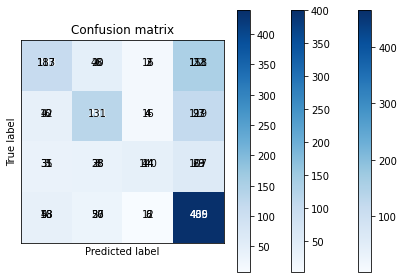

In [45]:
# Confusion Matrices and F1-Micro Scores
visual_f1 = f1_score(total_visual_targets, total_visual_predicted, average='micro')
visual_cm = confusion_matrix(total_visual_targets, total_visual_predicted)

classes = np.ndarray([0,1,2,3])

print(f'Visual Confusion Matrix with F1 Score: {visual_f1}')
print('--------------------------------')
plot_confusion_matrix(visual_cm, classes)


## Early Fusion Multimodal Model

In [150]:
class EarlyFusionModel(nn.Module):
    def __init__(self, acoustic_pool_size, visual_pool_1_size, visual_pool_2_size):
        super(EarlyFusionModel, self).__init__()
        
        # Lexical Section
        
        self.fc1 = nn.Linear(1088, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        # Acoustic Section
        
        self.acoustic_conv1 = nn.Conv1d(in_channels=24, kernel_size=1, out_channels=16).float()
        self.acoustic_conv2 = nn.Conv1d(in_channels=16, kernel_size=1, out_channels=8).float()
        self.acoustic_pool1 = nn.MaxPool1d(acoustic_pool_size, stride=acoustic_pool_size)
        self.acoustic_batch1 = nn.BatchNorm1d(16)
        self.acoustic_batch2 = nn.BatchNorm1d(8)
        
        # Visual Section
        
        self.visual_conv1 = nn.Conv1d(in_channels=716, kernel_size=1, out_channels=8).double()
        self.visual_batch1 = nn.BatchNorm1d(8)
        self.visual_pool1 = nn.MaxPool1d(visual_pool_1_size, stride=visual_pool_1_size)
        self.visual_pool2 = nn.MaxPool1d(visual_pool_2_size, stride=visual_pool_2_size)
        self.visual_conv2 = nn.Conv1d(in_channels=8, kernel_size=1, out_channels=1).double()
        self.visual_batch2 = nn.BatchNorm1d(1)

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
      
    def forward(self, lexical, acoustic, visual):
        # Performs Convolutional layers on Acoustic and Visual data, then flattens and connects with Lexical Data for fully connected network
        
        # Acoustic Section
        
        acoustic = self.acoustic_conv1(acoustic.double())
        acoustic = self.acoustic_batch1(acoustic)
        acoustic = self.relu(acoustic)
        acoustic = self.acoustic_pool1(acoustic)
        acoustic = self.dropout(acoustic)
        
        acoustic = self.acoustic_conv2(acoustic)
        acoustic = self.acoustic_batch2(acoustic)
        acoustic = self.relu(acoustic)
        acoustic = self.acoustic_pool1(acoustic)
        
        acoustic = self.flatten(acoustic)
        
        # Visual Section
        
        visual = self.visual_conv1(visual)
        visual = self.visual_batch1(visual)
        visual = self.relu(visual)
        visual = self.visual_pool1(visual)
        
        visual = self.dropout(visual)
        
        visual = self.visual_conv2(visual)
        visual = self.visual_batch2(visual)
        visual = self.relu(visual)
        visual = self.visual_pool2(visual)
        
        visual = self.flatten(visual)
        
        # Combine
        combined = torch.cat([lexical, acoustic, visual],dim=1)
        
        combined = self.fc1(combined)
        combined = self.relu(combined)
        combined = self.dropout(combined)
        
        combined = self.fc2(combined)
        combined = self.relu(combined)
        
        combined = self.fc3(combined)
        return combined

## Training and Testing Early Fusion MM Model

In [156]:
early_multi = EarlyFusionModel(acoustic_pool_size=2,visual_pool_1_size=8, visual_pool_2_size=4).double()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(early_multi.parameters(), lr=1e-4)

k_folds = 10
num_epochs = 5

total_combined_predicted, total_combined_targets = [], []

k_fold_results = {}

kfold = KFold(n_splits=k_folds, shuffle=True)


for fold, (train_ids, test_ids) in enumerate(kfold.split(visual_dataset)):
    print(f"Fold {fold}")
    print('----------------------------')
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    visual_trainloader = torch.utils.data.DataLoader(visual_dataset, batch_size=10,
                                          sampler=train_subsampler)
    visual_testloader = torch.utils.data.DataLoader(visual_dataset, batch_size=10,
                                          sampler=test_subsampler)
    
    acoustic_trainloader = torch.utils.data.DataLoader(acoustic_dataset, batch_size=10,
                                          sampler=train_subsampler)
    acoustic_testloader = torch.utils.data.DataLoader(acoustic_dataset, batch_size=10,
                                          sampler=test_subsampler)
    
    lexical_trainloader = torch.utils.data.DataLoader(lexical_dataset, batch_size=10,
                                          sampler=train_subsampler)
    lexical_testloader = torch.utils.data.DataLoader(lexical_dataset, batch_size=10,
                                          sampler=test_subsampler)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
#         print(type(combined_trainloader.dataset))
        running_loss = 0.0
        for lexical, acoustic, visual in zip(lexical_trainloader, acoustic_trainloader, visual_trainloader):
            # get the inputs; data is a list of [inputs, labels]
            
            lexical_data, lexical_label = lexical
            acoustic_data, acoustic_label = acoustic
            visual_data, visual_label = visual
            
            
            
            # zero the parameter gradients
            optimizer.zero_grad()

            
            # Generate outputs
            outputs = early_multi(lexical_data, acoustic_data, visual_data)
            
            # forward + backward + optimize
            loss = criterion(outputs, lexical_label)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            
            if i % 100 == 99:    # print every 200 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training - Testing Begins')
    
    correct, total = 0,0
    
    with torch.no_grad():
        # Iterate over the test data and generate predictions
        for lexical, acoustic, visual in zip(lexical_testloader, acoustic_testloader, visual_testloader):

            # Get inputs
            lexical_data, lexical_label = lexical
            acoustic_data, acoustic_label = acoustic
            visual_data, visual_label = visual
            
            
            # Generate outputs
            outputs = early_multi(lexical_data, acoustic_data, visual_data)
            
            # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            
            total_combined_predicted += predicted
            total_combined_targets += lexical_label
            
            total += lexical_label.size(0)
            correct += (predicted == lexical_label).sum().item()
        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')
        k_fold_results[fold] = 100.0 * (correct / total)
    
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in k_fold_results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(k_fold_results.items())} %')

Fold 0
----------------------------
Finished Training - Testing Begins
Accuracy for fold 0: 53 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 53.73134328358209 %
Average: 53.73134328358209 %
Fold 1
----------------------------
Finished Training - Testing Begins
Accuracy for fold 1: 46 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 53.73134328358209 %
Fold 1: 46.26865671641791 %
Average: 50.0 %
Fold 2
----------------------------
Finished Training - Testing Begins
Accuracy for fold 2: 61 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 53.73134328358209 %
Fold 1: 46.26865671641791 %
Fold 2: 61.940298507462686 %
Average: 53.980099502487555 %
Fold 3
----------------------------


KeyboardInterrupt: 

## Early Fusion Results and Confusion Matrix

In [ ]:
# Confusion Matrices and F1-Micro Scores
early_f1 = f1_score(total_combined_targets, total_combined_predicted, average='micro')
early_cm = confusion_matrix(total_combined_targets, total_combined_predicted)

classes = np.ndarray([0,1,2,3])

print(f'Early Fusion Confusion Matrix with F1 Score: {early_f1}')
print('--------------------------------')
plot_confusion_matrix(early_cm, classes)

## Late Fusion Multimodal Model

In [159]:
lex = LexicalModel()
acoust = AcousticModel(pool_size=2)
visual = VisualModel(pool_1_size=8, pool_2_size=4).double()


criterion = nn.CrossEntropyLoss()
lex_optimizer = optim.Adam(lex.parameters(), lr=1e-4)
acoust_optimizer = optim.Adam(acoust.parameters(), lr=1e-4)
visual_optimizer = optim.Adam(visual.parameters(), lr=1e-4)

k_folds = 10
num_epochs = 10

late_combined_predicted, late_combined_targets = [], []

k_fold_results = {}

kfold = KFold(n_splits=k_folds, shuffle=True)


for fold, (train_ids, test_ids) in enumerate(kfold.split(visual_dataset)): # arbitrarily pick visual
    print(f"Fold {fold}")
    print('----------------------------')
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    visual_trainloader = torch.utils.data.DataLoader(visual_dataset, batch_size=10,
                                          sampler=train_subsampler)
    visual_testloader = torch.utils.data.DataLoader(visual_dataset, batch_size=10,
                                          sampler=test_subsampler)
    
    acoustic_trainloader = torch.utils.data.DataLoader(acoustic_dataset, batch_size=10,
                                          sampler=train_subsampler)
    acoustic_testloader = torch.utils.data.DataLoader(acoustic_dataset, batch_size=10,
                                          sampler=test_subsampler)
    
    lexical_trainloader = torch.utils.data.DataLoader(lexical_dataset, batch_size=10,
                                          sampler=train_subsampler)
    lexical_testloader = torch.utils.data.DataLoader(lexical_dataset, batch_size=10,
                                          sampler=test_subsampler)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
#         print(type(combined_trainloader.dataset))
        running_loss = 0.0
        for lexical, acoustic, vis in zip(lexical_trainloader, acoustic_trainloader, visual_trainloader):
            # get the inputs; data is a list of [inputs, labels]
            
            lexical_data, lexical_label = lexical
            acoustic_data, acoustic_label = acoustic
            visual_data, visual_label = vis
            
            
            
            # zero the parameter gradients
            lex_optimizer.zero_grad()
            acoust_optimizer.zero_grad()
            visual_optimizer.zero_grad()
            
            # Generate outputs
            lex_outputs = lex(lexical_data)
            acoust_outputs = acoust(acoustic_data)
            visual_outputs = visual(visual_data)

            
            
            #lexical 
            # forward + backward + optimize
            lex_loss = criterion(lex_outputs, lexical_label)
            lex_loss.backward()
            lex_optimizer.step()
            
            acoust_loss = criterion(acoust_outputs, acoustic_label)
            acoust_loss.backward()
            acoust_optimizer.step()
            
            visual_loss = criterion(visual_outputs, visual_label)
            visual_loss.backward()
            visual_optimizer.step()
            
            

            # print statistics
            running_loss += loss.item()
            
            if i % 100 == 99:    # print every 200 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training - Testing Begins')
    
    correct, total = 0,0
    
    with torch.no_grad():
        # Iterate over the test data and generate predictions
        for lexical, acoustic, vis in zip(lexical_testloader, acoustic_testloader, visual_testloader):

            # Get inputs
            lexical_data, lexical_label = lexical
            acoustic_data, acoustic_label = acoustic
            visual_data, visual_label = vis
            
            
            # Generate outputs
            lex_outputs = lex(lexical_data)
            acoust_outputs = acoust(acoustic_data)
            visual_outputs = visual(visual_data)
            
            total_outputs = lex_outputs + acoust_outputs + visual_outputs
            
            # Set total and correct
            _, predicted = torch.max(total_outputs.data, 1)
            
            late_combined_predicted += predicted
            late_combined_targets += lexical_label
            
            total += lexical_label.size(0)
            correct += (predicted == lexical_label).sum().item()
        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')
        k_fold_results[fold] = 100.0 * (correct / total)
    
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in k_fold_results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(k_fold_results.items())} %')

Fold 0
----------------------------
Finished Training - Testing Begins
Accuracy for fold 0: 42 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 42.53731343283582 %
Average: 42.53731343283582 %
Fold 1
----------------------------
Finished Training - Testing Begins
Accuracy for fold 1: 53 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 42.53731343283582 %
Fold 1: 53.73134328358209 %
Average: 48.13432835820896 %
Fold 2
----------------------------
Finished Training - Testing Begins
Accuracy for fold 2: 62 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 42.53731343283582 %
Fold 1: 53.73134328358209 %
Fold 2: 62.68656716417911 %
Average: 52.985074626865675 %
Fold 3
----------------------------
Finished Training - Testing Begins
Accuracy for fold 3: 71 %
-----------------------

## Late Fusion Results with Confusion Matrix

In [ ]:
# Confusion Matrices and F1-Micro Scores
late_f1 = f1_score(late_combined_predicted, late_combined_predicted, average='micro')
late_cm = confusion_matrix(late_combined_predicted, late_combined_predicted)

classes = np.ndarray([0,1,2,3])

print(f'Late Fusion Confusion Matrix with F1 Score: {late_f1}')
print('--------------------------------')
plot_confusion_matrix(late_cm, classes)